# **Analyzing Sentiments in Amazon Musical Instruments Reviews**

---

This notebook contains a Sentiment Analysis Project focused on Amazon Musical Instruments Reviews. Sentiment analysis is a valuable natural language processing (NLP) technique with profound implications for business development, as it provides invaluable insights into customer opinions. In this project, I explore the Amazon Musical Instruments Reviews dataset, perform exploratory data analysis (EDA), and build a sentiment analysis model.

# Libraries

**Data Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**NLP Text Libraries**

In [ ]:
import string
import re
import nltk
import nltk.corpus
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# !pip3 install textblob
# !pip3 install WordCloud
# !pip3 install imblearn

**EDA Analysis**

In [ ]:
# Text Polarity
from textblob import TextBlob

# Text Vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Word Cloud
from wordcloud import WordCloud

**Feature Engineering**

In [ ]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

# TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Resampling
from imblearn.over_sampling import SMOTE
from collections import Counter

# Splitting Dataset
from sklearn.model_selection import train_test_split

**Model Selection and Evaluation**

In [ ]:
# Model Building
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Model Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report



---



# Dataset

The dataset I'll be utilizing is sourced from Kaggle and is accessible for download under the title [`Amazon Musical Instruments Reviews`](https://www.kaggle.com/eswarchandt/amazon-music-reviews?select=Musical_instruments_reviews.csv)

This dataset is available in two formats: JSON and CSV. For my project, I have opted to work with the CSV version. In essence, this dataset captures the feedback provided by customers following their purchases of musical instruments from Amazon.

**Read The Dataset**

In [ ]:
dataset = pd.read_csv("Instruments_Reviews.csv")

**Shape of The Dataset**

In [ ]:
dataset.shape

(10261, 9)

Based on this, it can be deduced that the dataset comprises 10,261 rows and 9 columns.



---



# Data Preprocessing

**Checking Null Values**

In [ ]:
dataset.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

As indicated earlier, the dataset contains two columns with null values: 'reviewText' and 'reviewerName'. Although the presence of null values in the 'reviewerName' column is not of critical importance, the primary concern should be on the 'reviewText' column. Removing these rows is not an option since the ratings and summaries provided by customers will influence the model's performance later, even though the number of missing rows is relatively small. To address this issue, the empty values are filled with an empty string.

**Filling Missing Values**

In [ ]:
dataset.reviewText.fillna(value = "", inplace = True)

**Concatenate `reviewText` and `summary` Columns**

In [ ]:
dataset["reviews"] = dataset["reviewText"] + " " + dataset["summary"]
dataset.drop(columns = ["reviewText", "summary"], axis = 1, inplace = True)

**Statistic Description of The Dataset**

In [ ]:
dataset.describe(include = "all")

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews
count,10261,10261,10234,10261,10261.000000,1.026100e+04,10261,10261
unique,1429,900,1397,269,NaN,NaN,1570,10261
top,ADH0O8UVJOT10,B003VWJ2K8,Amazon Customer,"[0, 0]",NaN,NaN,"01 22, 2013","Not much to write about here, but it does exac..."
freq,42,163,66,6796,NaN,NaN,40,1
mean,NaN,NaN,NaN,NaN,4.488744,1.360606e+09,NaN,NaN
std,NaN,NaN,NaN,NaN,0.894642,3.779735e+07,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000,1.095466e+09,NaN,NaN
25%,NaN,NaN,NaN,NaN,4.000000,1.343434e+09,NaN,NaN
50%,NaN,NaN,NaN,NaN,5.000000,1.368490e+09,NaN,NaN
75%,NaN,NaN,NaN,NaN,5.000000,1.388966e+09,NaN,NaN


From the description provided, it becomes evident that customers' ratings fall within the range of [1, 5], as indicated. Additionally, the average rating for musical instruments sold stands at 4.48. It's worth noting the presence of the new column, 'reviews,' which serves the purpose of concatenating both 'summary' and 'reviewText.

**Percentages of Ratings Given from The Customers**

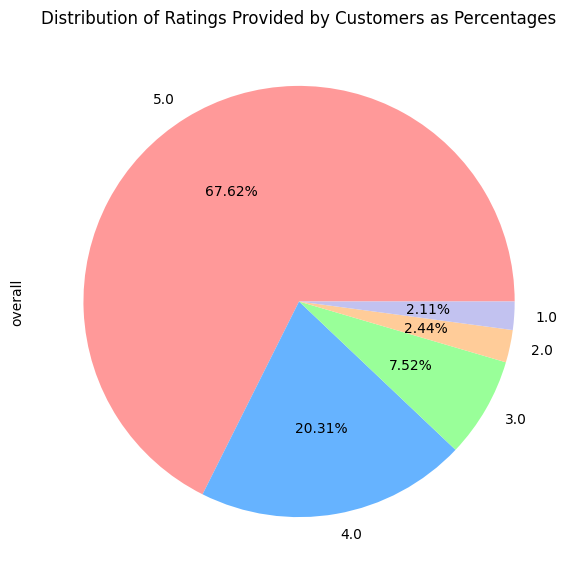

In [ ]:
custom_colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6']
dataset.overall.value_counts().plot(kind = "pie", legend = False, autopct = "%1.2f%%", fontsize = 10, figsize=(7,7), colors=custom_colors )
plt.title("Distribution of Ratings Provided by Customers as Percentages", loc = "center")
plt.show()

As illustrated by the chart above, a substantial proportion of musical instruments sold on Amazon boasts perfect 5.0 ratings, signifying their excellent condition. When classifying ratings greater than 3 as 'positive,' ratings equal to 3 as 'neutral,' and ratings below 3 as 'negative,' it's evident that the dataset contains a relatively small number of negative reviews. This factor might have implications for the model's performance in future analyses

**Labelling Products Based On Ratings Given**

The dataset lacks a dependent variable, meaning there is no established prediction target at this point. Sentiments will be assigned to each entry based on the previously described criteria: 'Positive Label' for products with ratings greater than 3.0, 'Neutral Label' for products with ratings equal to 3.0, and 'Negative Label' for the rest.

In [ ]:
def Labelling(Rows):
  if(Rows["overall"] > 3.0):
    Label = "Positive"
  elif(Rows["overall"] < 3.0):
    Label = "Negative"
  else:
    Label = "Neutral"
  return Label

In [ ]:
dataset["sentiment"] = dataset.apply(Labelling, axis = 1)

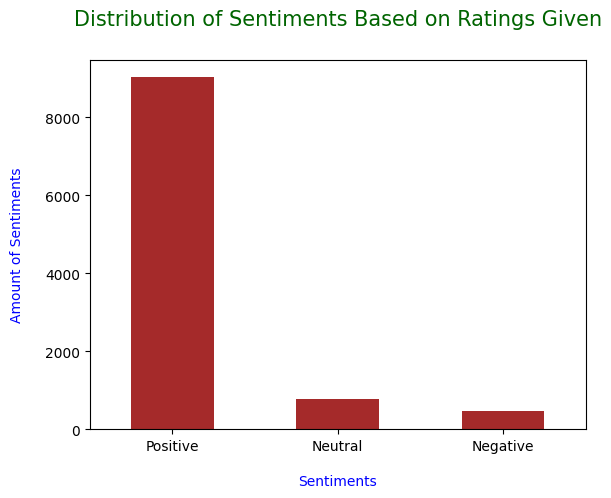

In [ ]:
dataset["sentiment"].value_counts().plot(kind = "bar", color = "brown")
plt.title("Distribution of Sentiments Based on Ratings Given", loc = "center", fontsize = 15, color = "darkgreen", pad = 25)
plt.xlabel("Sentiments", color = "blue", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Amount of Sentiments", color = "blue", fontsize = 10, labelpad = 15)
plt.show()

In this section, the option to convert the labels into numeric values is available, but for experimental purposes, this conversion will be deferred. It's worth noting that the graph illustrates the prevalence of positive sentiments within the dataset, aligning with the earlier observations.



---



# Text Preprocessing

**Text Cleaning**

In [ ]:
def Text_Cleaning(Text):
  # Lowercase the texts
  Text = Text.lower()

  # Cleaning punctuations in the text
  punc = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  Text = Text.translate(punc)

  # Removing numbers in the text
  Text = re.sub(r'\d+', '', Text)

  # Remove possible links
  Text = re.sub('https?://\S+|www\.\S+', '', Text)

  # Deleting newlines
  Text = re.sub('\n', '', Text)

  return Text

**Text Processing**

In [ ]:
# Stopwords
Stopwords = set(nltk.corpus.stopwords.words("english")) - set(["not"])

def Text_Processing(Text):
  Processed_Text = list()
  Lemmatizer = WordNetLemmatizer()

  # Tokens of Words
  Tokens = nltk.word_tokenize(Text)

  # Removing Stopwords and Lemmatizing Words
  # To reduce noises in our dataset, also to keep it simple and still
  # powerful, we will only omit the word `not` from the list of stopwords

  for word in Tokens:
    if word not in Stopwords:
      Processed_Text.append(Lemmatizer.lemmatize(word))

  return(" ".join(Processed_Text))

**Applying The Functions**

In [ ]:
dataset["reviews"] = dataset["reviews"].apply(lambda Text: Text_Cleaning(Text))
dataset["reviews"] = dataset["reviews"].apply(lambda Text: Text_Processing(Text))



---



# Exploratory Data Analysis

**Overview of The Dataset**

In [ ]:
dataset.head(n = 10)

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews,sentiment
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5.0,1393545600,"02 28, 2014",not much write exactly supposed filter pop sou...,Positive
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5.0,1363392000,"03 16, 2013",product exactly quite affordable not realized ...,Positive
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5.0,1377648000,"08 28, 2013",primary job device block breath would otherwis...,Positive
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5.0,1392336000,"02 14, 2014",nice windscreen protects mxl mic prevents pop ...,Positive
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5.0,1392940800,"02 21, 2014",pop filter great look performs like studio fil...,Positive
5,A2A039TZMZHH9Y,B00004Y2UT,"Bill Lewey ""blewey""","[0, 0]",5.0,1356048000,"12 21, 2012",good bought another one love heavy cord gold c...,Positive
6,A1UPZM995ZAH90,B00004Y2UT,Brian,"[0, 0]",5.0,1390089600,"01 19, 2014",used monster cable year good reason lifetime w...,Positive
7,AJNFQI3YR6XJ5,B00004Y2UT,"Fender Guy ""Rick""","[0, 0]",3.0,1353024000,"11 16, 2012",use cable run output pedal chain input fender ...,Neutral
8,A3M1PLEYNDEYO8,B00004Y2UT,"G. Thomas ""Tom""","[0, 0]",5.0,1215302400,"07 6, 2008",perfect epiphone sheraton ii monster cable wel...,Positive
9,AMNTZU1YQN1TH,B00004Y2UT,Kurt Robair,"[0, 0]",5.0,1389139200,"01 8, 2014",monster make best cable lifetime warranty does...,Positive


Based on the overview provided, it's clear that the 'reviews' feature holds significance in the upcoming sentiment analysis. This feature will be employed to predict the classification of sentiment.

**About Other Features**

In [ ]:
dataset.describe(include = "all")

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews,sentiment
count,10261,10261,10234,10261,10261.000000,1.026100e+04,10261,10261,10261
unique,1429,900,1397,269,NaN,NaN,1570,10254,3
top,ADH0O8UVJOT10,B003VWJ2K8,Amazon Customer,"[0, 0]",NaN,NaN,"01 22, 2013",good string five star,Positive
freq,42,163,66,6796,NaN,NaN,40,3,9022
mean,NaN,NaN,NaN,NaN,4.488744,1.360606e+09,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,0.894642,3.779735e+07,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000,1.095466e+09,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,4.000000,1.343434e+09,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,5.000000,1.368490e+09,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,5.000000,1.388966e+09,NaN,NaN,NaN


**Statistical description of the dataset** : Notably, the other features in the dataset seem to have limited relevance when it comes to determining sentiment in later stages. While the 'helpful' aspect could be considered for inclusion in the model, the description provided earlier indicates that the prevailing values are [0,0], signaling that a substantial number of users do not actively participate in voting. As a result, it can be inferred that this feature may not be a critical element for the model.

**Polarity, Review Length, and Word Counts**

In order to substantiate the analysis conducted previously, an in-depth exploration of the dataset will be undertaken, emphasizing the polarity of the texts and the language employed within the reviews. This exploration will involve the creation of supplementary dataset columns and the presentation of corresponding visualizations.

**Polarity**

In [ ]:
dataset["polarity"] = dataset["reviews"].map(lambda Text: TextBlob(Text).sentiment.polarity)

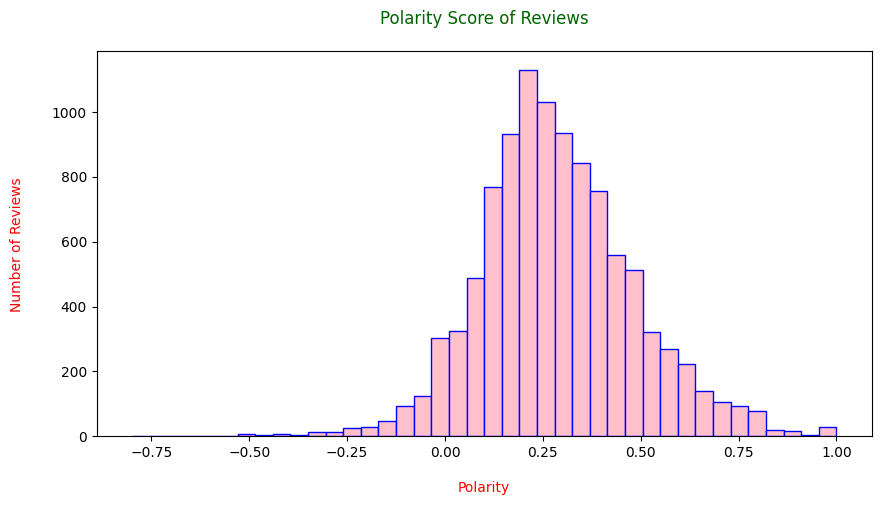

In [ ]:
dataset["polarity"].plot(kind = "hist", bins = 40, edgecolor = "blue", linewidth = 1, color = "pink", figsize = (10,5))
plt.title("Polarity Score of Reviews", color = "darkgreen", pad = 20)
plt.xlabel("Polarity", labelpad = 15, color = "red")
plt.ylabel("Number of Reviews", labelpad = 20, color = "red")

plt.show()

Reviews with a negative polarity fall within the range of [-1, 0), while neutral sentiments are represented as 0.0, and positive reviews are in the range (0, 1].

Examining the histogram displayed above, it becomes apparent that the majority of reviews are situated in the realm of positive sentiments, affirming the accuracy of the earlier analysis. From a statistical standpoint, the histogram illustrates that our data exhibits a normal distribution, although not precisely a standard one. In summary, the analysis concerning the distribution of sentiment quantities within the reviews aligns accurately with the depicted histogram.

Review Length

In [ ]:
dataset["length"] = dataset["reviews"].astype(str).apply(len)

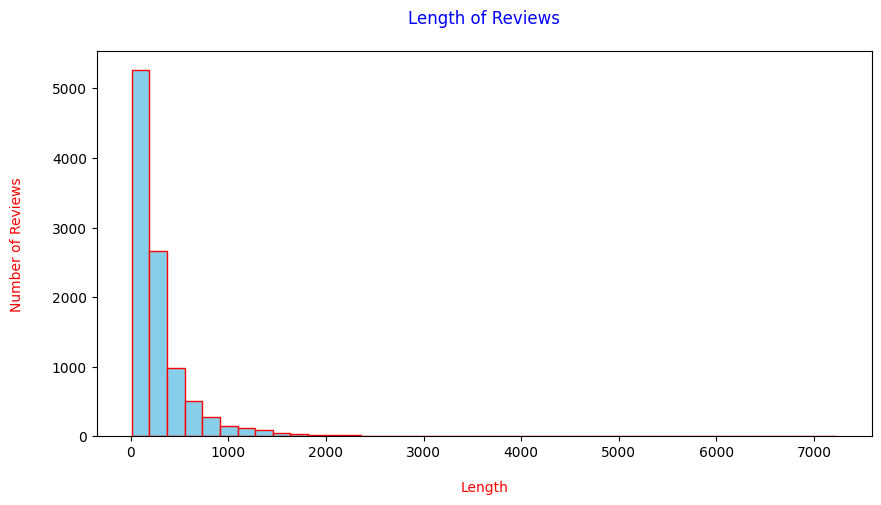

In [ ]:
dataset["length"].plot(kind = "hist", bins = 40, edgecolor = "red", linewidth = 1, color = "skyblue", figsize = (10,5))
plt.title("Length of Reviews", color = "blue", pad = 20)
plt.xlabel("Length", labelpad = 15, color = "red")
plt.ylabel("Number of Reviews", labelpad = 20, color = "red")

plt.show()

From this data, it's evident that the text length in the reviews falls within the range of approximately 0 to 1000 characters. The distribution exhibits positive skewness, indicating a rightward skew, which implies that reviews with lengths exceeding 1000 characters are relatively rare. It's important to note that the text preprocessing phase can impact the reported review length, as certain words may have been omitted. This also applies when calculating the total word count in the reviews

Word Counts

In [ ]:
dataset["word_counts"] = dataset["reviews"].apply(lambda x: len(str(x).split()))

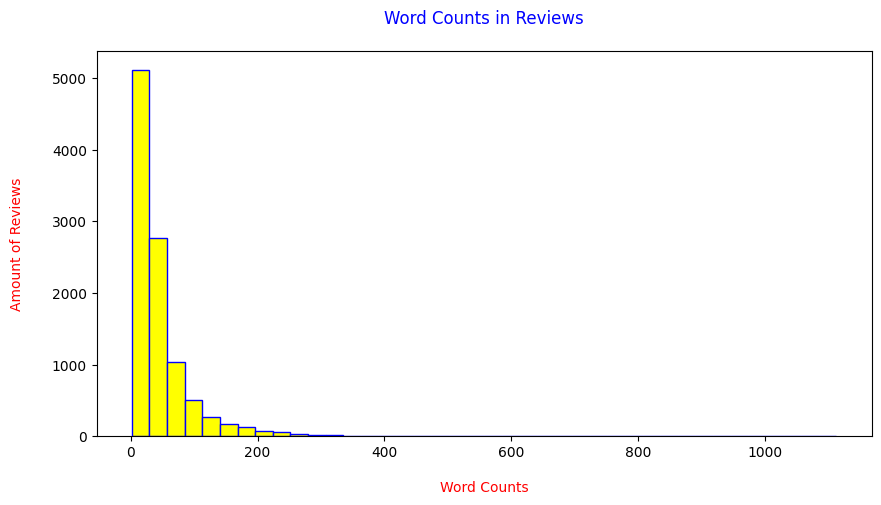

In [ ]:
dataset["word_counts"].plot(kind = "hist", bins = 40, edgecolor = "blue", linewidth = 1, color = "yellow", figsize = (10,5))
plt.title("Word Counts in Reviews", color = "blue", pad = 20)
plt.xlabel("Word Counts", labelpad = 15, color = "red")
plt.ylabel("Amount of Reviews", labelpad = 20, color = "red")

plt.show()

The depicted graph suggests that the majority of reviews contain between 0 and 200 words. Similar to the previous observation, the distribution displays a rightward skew, and the computation is influenced by the text preprocessing conducted earlier.

# N-Gram Analysis

**N-Gram Function**

In [ ]:
def Gram_Analysis(Corpus, Gram, N):
  # Vectorizer
  Vectorizer = CountVectorizer(stop_words = list(Stopwords), ngram_range=(Gram,Gram))
  # Vectorizer = CountVectorizer(stop_words="english", ngram_range=(Gram,Gram))

  # N-Grams Matrix
  ngrams = Vectorizer.fit_transform(Corpus)

  # N-Grams Frequency
  Count = ngrams.sum(axis=0)

  # List of Words
  words = [(word, Count[0, idx]) for word, idx in Vectorizer.vocabulary_.items()]

  # Sort Descending With Key = Count
  words = sorted(words, key = lambda x:x[1], reverse = True)

  return words[:N]

**Filter The DataFrame Based On Sentiments**

In [ ]:
# Use dropna() so the base DataFrame is not affected
Positive = dataset[dataset["sentiment"] == "Positive"].dropna()
Neutral = dataset[dataset["sentiment"] == "Neutral"].dropna()
Negative = dataset[dataset["sentiment"] == "Negative"].dropna()

**Unigram of Reviews Based on Sentiments**

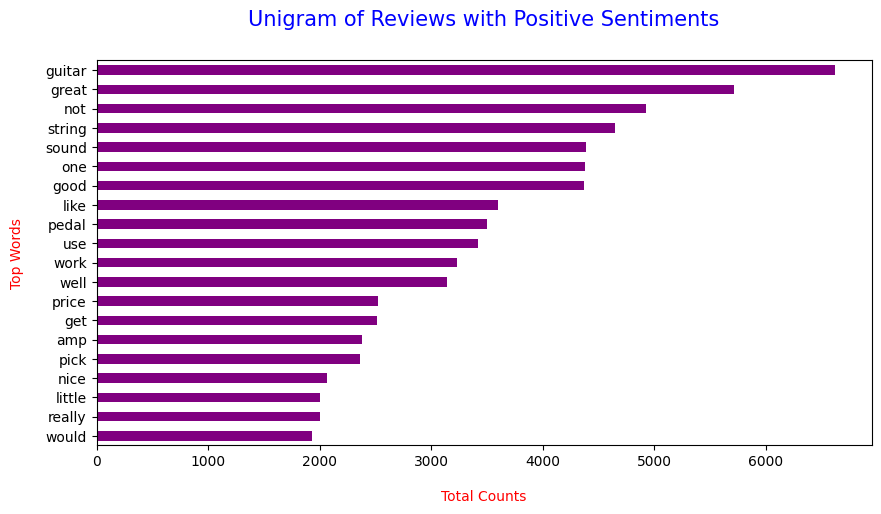

In [ ]:
# Finding Unigram

words = Gram_Analysis(Positive["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "purple", figsize = (10, 5))
plt.title("Unigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "red", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "red", fontsize = 10, labelpad = 15)
plt.show()

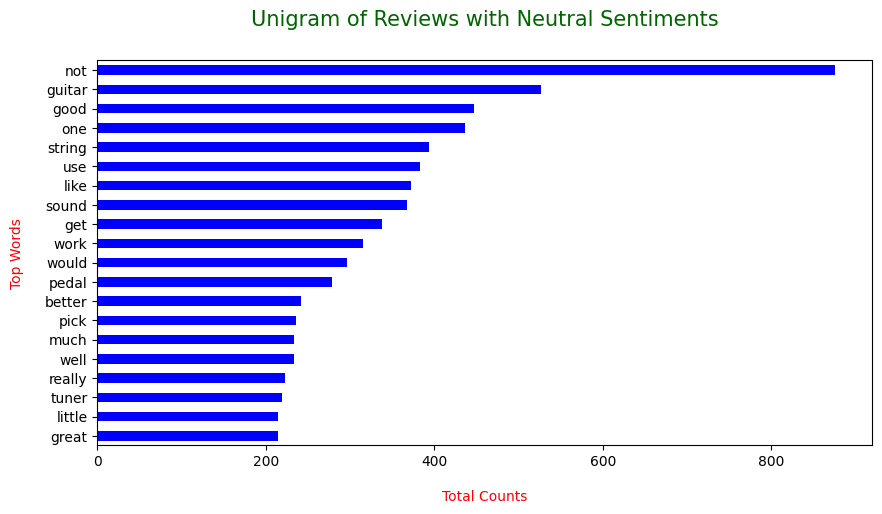

In [ ]:
# Finding Unigram
words = Gram_Analysis(Neutral["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "blue", figsize = (10, 5))
plt.title("Unigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "darkgreen", pad = 25)
plt.xlabel("Total Counts", color = "red", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "red", fontsize = 10, labelpad = 15)
plt.show()

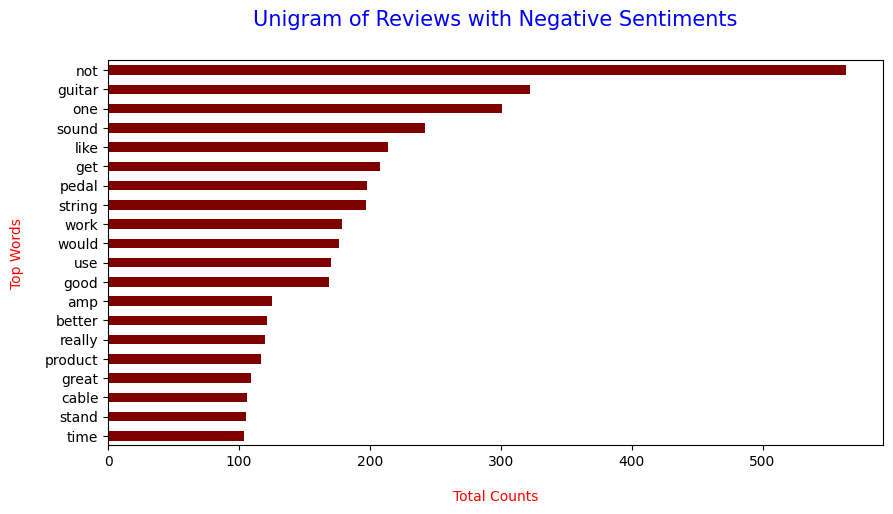

In [ ]:
# Finding Unigram
words = Gram_Analysis(Negative["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "maroon", figsize = (10, 5))
plt.title("Unigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "red", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "red", fontsize = 10, labelpad = 15)
plt.show()

The accuracy of these unigrams is somewhat limited, as it's evident that even in the case of positive sentiments, the most prominent unigram is the word 'guitar,' which refers to an object. Nonetheless, this observation does provide insight into the fact that the most frequently purchased items appear to be guitars or related products. It might be beneficial to explore bigrams to obtain a more accurate description of each sentiment

**Bigram of Reviews Based On Sentiments**

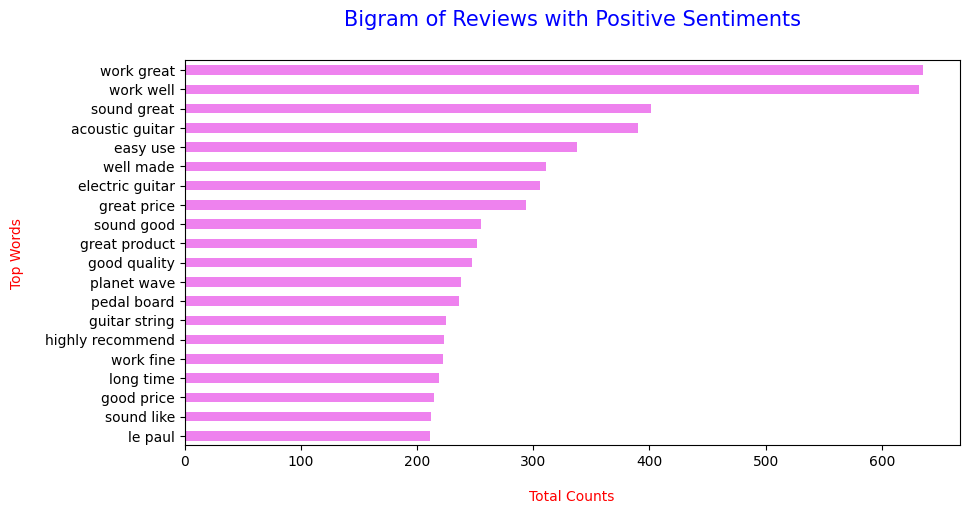

In [ ]:
# Finding Bigram
words = Gram_Analysis(Positive["reviews"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "violet", figsize = (10, 5))
plt.title("Bigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "red", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "red", fontsize = 10, labelpad = 15)
plt.show()

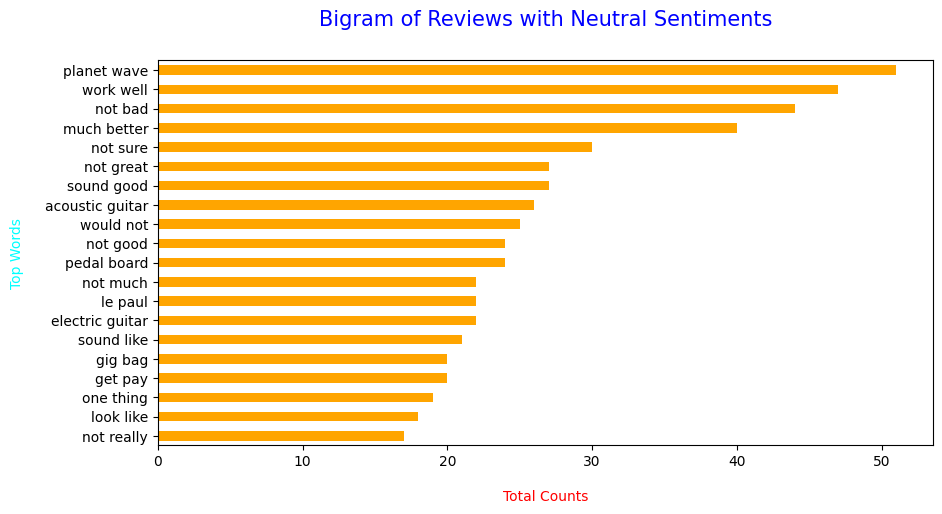

In [ ]:
# Finding Bigram
words = Gram_Analysis(Neutral["reviews"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
plt.title("Bigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "red", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

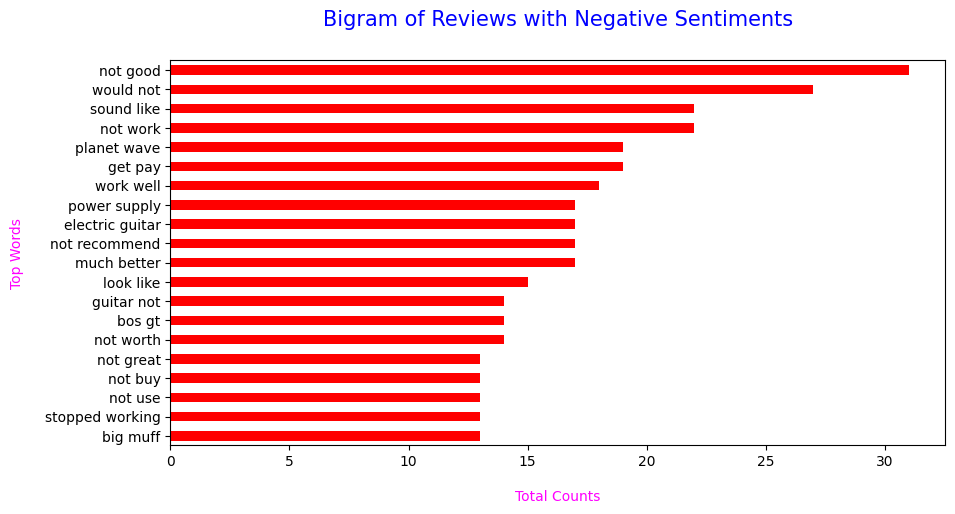

In [ ]:
# Finding Bigram
words = Gram_Analysis(Negative["reviews"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
plt.title("Bigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "magenta", fontsize = 10, labelpad = 15)
plt.show()

Bigrams demonstrate superior performance compared to unigrams, as they enable the identification of phrases that genuinely encapsulate positive sentiments. Nevertheless, it's noteworthy that in certain instances, the top phrases still include references to guitar-related objects, reinforcing the notion that the most commonly purchased items are associated with guitars.

**Trigram of Reviews Based On Sentiments**

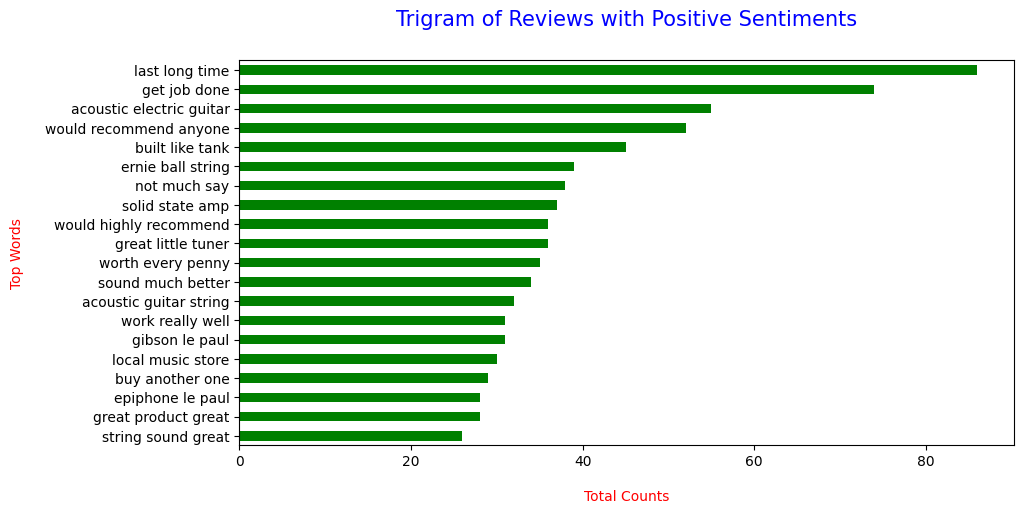

In [ ]:
# Finding Trigram
words = Gram_Analysis(Positive["reviews"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Trigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "red", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "red", fontsize = 10, labelpad = 15)
plt.show()

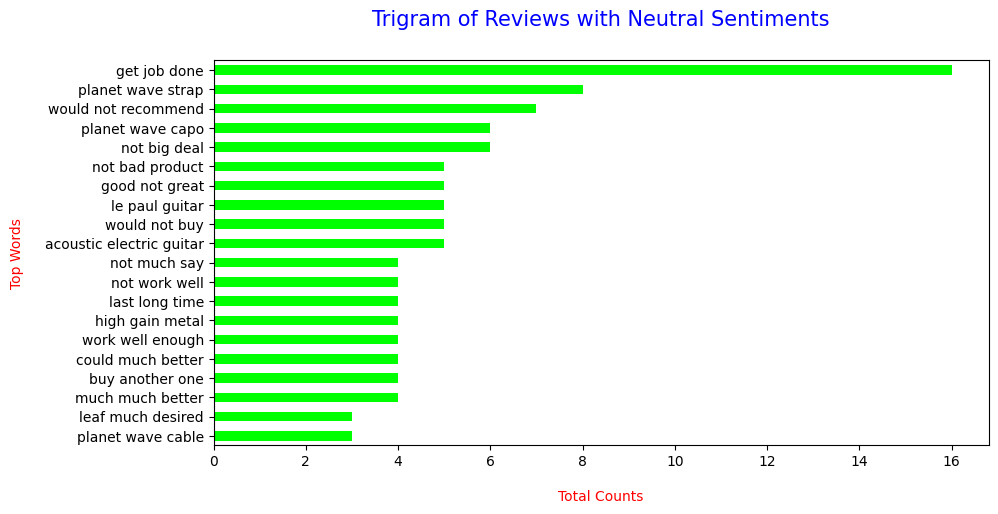

In [ ]:
# Finding Trigram
words = Gram_Analysis(Neutral["reviews"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "lime", figsize = (10, 5))
plt.title("Trigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "red", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "red", fontsize = 10, labelpad = 15)
plt.show()

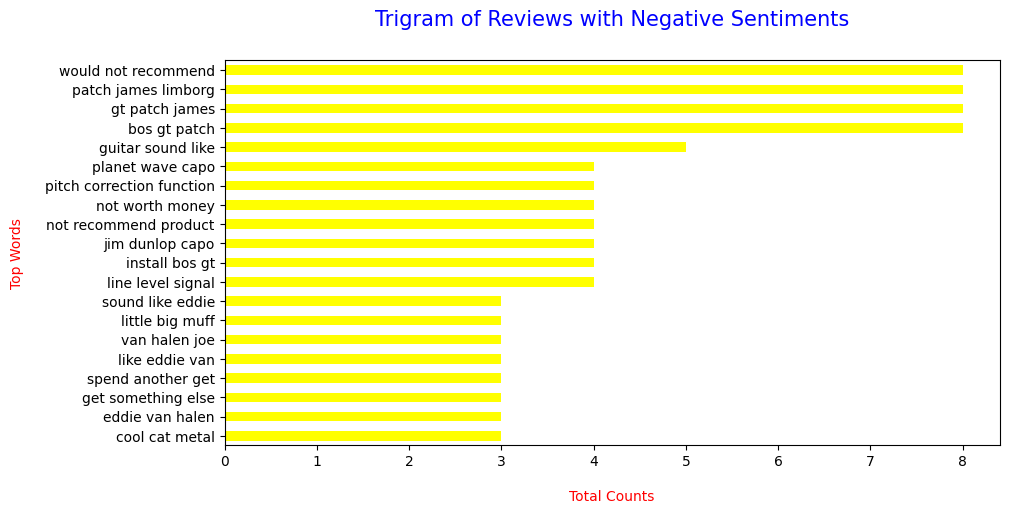

In [ ]:
# Finding Trigram
words = Gram_Analysis(Negative["reviews"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "yellow", figsize = (10, 5))
plt.title("Trigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "red", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "red", fontsize = 10, labelpad = 15)
plt.show()

Trigrams prove to be a somewhat more effective means of conveying each sentiment. Notably, negative trigrams provide substantial insights into subpar products, as indicated by the prominent terms listed above. The N-Gram Analysis also highlights the impact of retaining the word "not" in the list of stopwords, preserving the meaning of negation phrases within the data.



---



# Word Clouds

**Word Cloud of Reviews with Positive Sentiments**

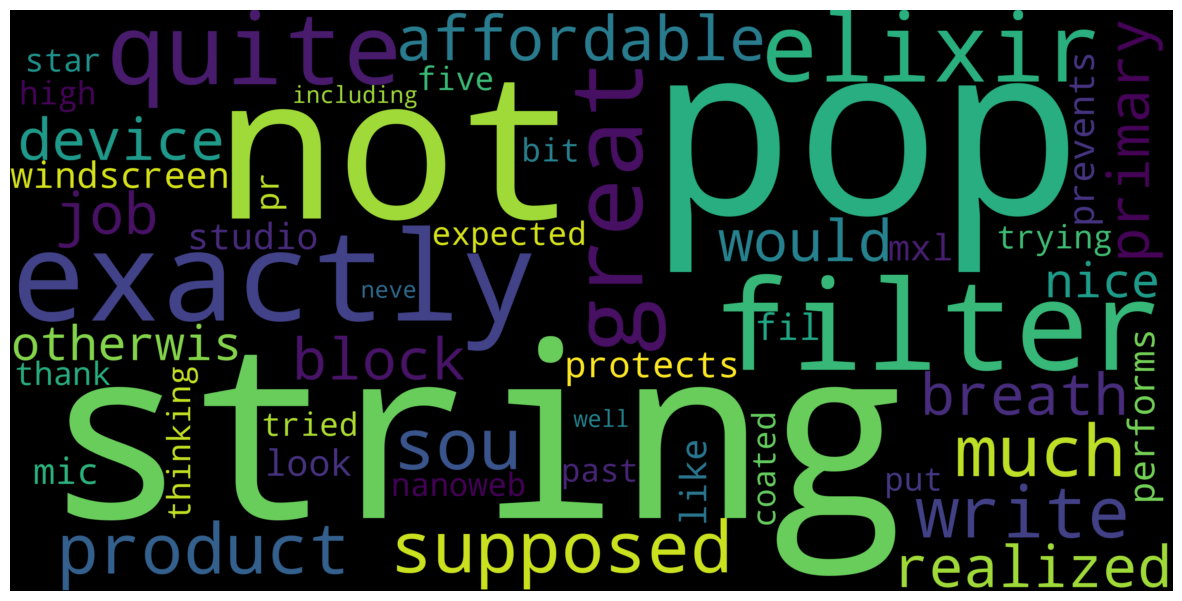

In [ ]:
from wordcloud import WordCloud
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = list(Stopwords)).generate(str(Positive["reviews"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

**Word Cloud of Reviews with Neutral Sentiments**

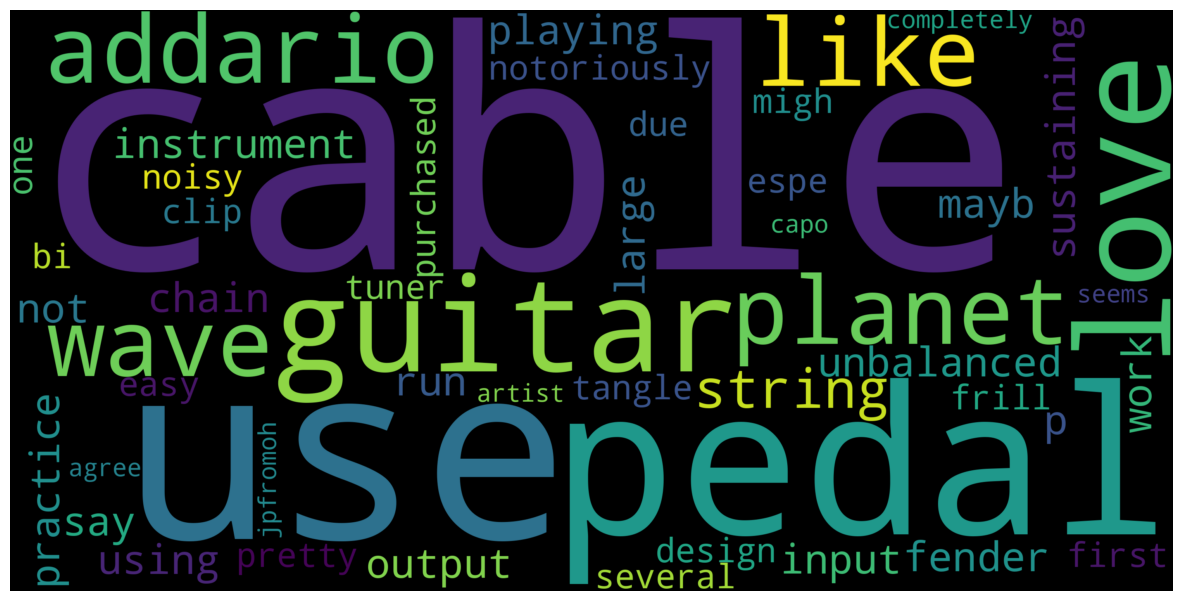

In [ ]:
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Neutral["reviews"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

**Word Cloud of Reviews with Negative Sentiments**

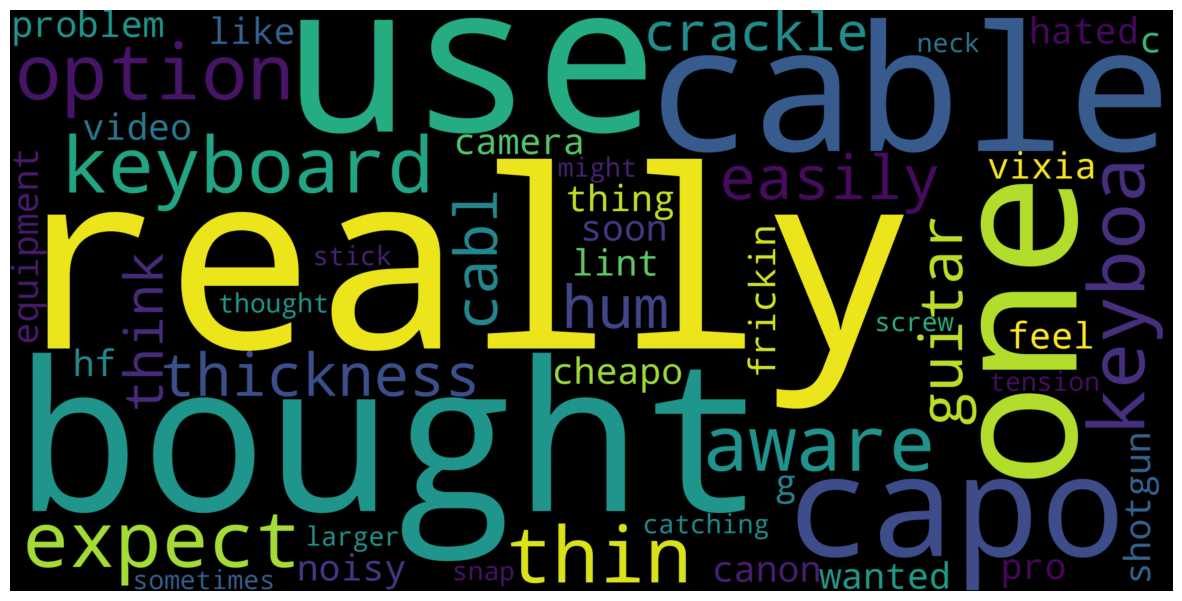

In [ ]:
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Negative["reviews"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

The word clouds reveal words that aptly convey the sentiments, and akin to the N-Grams Analysis, they also unveil discussions about objects in the reviews

# Feature Engineering

**Drop Insignificant Columns**

In [ ]:
Columns = ["reviewerID", "asin", "reviewerName", "helpful", "unixReviewTime", "reviewTime", "polarity", "length", "word_counts", "overall"]
dataset.drop(columns = Columns, axis = 1, inplace = True)

The elimination of these columns was carried out to streamline the dataset. At present, we are left with two columns serving as the independent variables, and the final column functions as the dependent variable. The next step involves the encoding of our labels into a numerical representation for each category

**Current State of The Dataset**

In [ ]:
dataset.head()

,reviews,sentiment
0,not much write exactly supposed filter pop sou...,Positive
1,product exactly quite affordable not realized ...,Positive
2,primary job device block breath would otherwis...,Positive
3,nice windscreen protects mxl mic prevents pop ...,Positive
4,pop filter great look performs like studio fil...,Positive


**Encoding Our Target Variable**

In [ ]:
Encoder = LabelEncoder()
dataset["sentiment"] = Encoder.fit_transform(dataset["sentiment"])

In [ ]:
dataset["sentiment"].value_counts()

2    9022
1     772
0     467
Name: sentiment, dtype: int64

The sentiment has been effectively encoded into numerical values to facilitate our model's comprehension. As seen earlier, the label 'Positive' corresponds to an encoding of 2, 'Neutral' to 1, and 'Negative' to 0. Now, the next step is to assign significance to individual words within the entire review by assigning them weights. This is accomplished using the TF-IDF (Term Frequency - Inverse Document Frequency) Vectorizer.

**TF-IDF Vectorizer**

In [ ]:
# Defining our vectorizer with total words of 5000 and with bigram model
TF_IDF = TfidfVectorizer(max_features = 5000, ngram_range = (2, 2))

# Fitting and transforming our reviews into a matrix of weighed words
# This will be our independent features
X = TF_IDF.fit_transform(dataset["reviews"])

# Check our matrix shape
X.shape

(10261, 5000)

In [ ]:
# Declaring our target variable
y = dataset["sentiment"]

Considering the shape of the transformed data using a TF-IDF Vectorizer with the top 7000 bigram words, it is evident that the dataset exhibits an imbalance, with significantly fewer instances of neutral and negative values in comparison to positive sentiments. Prior to proceeding with the modeling process, it is essential to address this imbalance by balancing the dataset.

**Resampling Our Dataset**

Multiple methods are available for resampling an imbalanced dataset, including options like the Bootstrap Method and SMOTE (Synthetic Minority Oversampling Technique). In this case, I will employ SMOTE, which involves the random generation of new replicates from our undersampled data to achieve a balanced dataset.

In [ ]:
Counter(y)

Counter({2: 9022, 1: 772, 0: 467})

In [ ]:
Balancer = SMOTE(random_state = 42)
X_final, y_final = Balancer.fit_resample(X, y)

In [ ]:
Counter(y_final)

Counter({2: 9022, 1: 9022, 0: 9022})

Currently, the data exhibits balance, which is evident when comparing the count of sentiment categories before and after the SMOTE resampling

**Splitting Our Dataset**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.25, random_state = 42)

The dataset was divided into training and test sets, allocated in a 75:25 proportion, respectively.



---



# Model Selection and Evaluation

Determining the most suitable model for the data is a task requiring exploration. Therefore, it is essential to assess various available classification models and select the best ones based on primary metrics such as the Confusion Matrix and F1 Score, while considering additional metrics as supplementary indicators. Initially, cross-validation techniques will be employed to identify the optimal model

**Model Building**

K-Fold Cross Validation is applied to the initial dataset (before resampling) due to its independence from the impact of imbalanced data. This method divides the dataset and considers every validation, making it a reliable choice. Utilizing Cross Validation on the balanced dataset achieved through resampling is expected to yield similar outcomes.

In [ ]:
DTree = DecisionTreeClassifier()
LogReg = LogisticRegression()
SVC = SVC()
RForest = RandomForestClassifier()
Bayes = BernoulliNB()
KNN = KNeighborsClassifier()

Models = [DTree, LogReg, SVC, RForest, Bayes, KNN]
Models_Dict = {0: "Decision Tree", 1: "Logistic Regression", 2: "SVC", 3: "Random Forest", 4: "Naive Bayes", 5: "K-Neighbors"}

for i, model in enumerate(Models):
  print("{} Test Accuracy: {}".format(Models_Dict[i], cross_val_score(model, X, y, cv = 10, scoring = "accuracy").mean()))

Decision Tree Test Accuracy: 0.8193148537252467
Logistic Regression Test Accuracy: 0.8818828283518491
SVC Test Accuracy: 0.8805184008381876
Random Forest Test Accuracy: 0.8771076642162585
Naive Bayes Test Accuracy: 0.8091794454219505
K-Neighbors Test Accuracy: 0.8799336055165503


Six models are available for consideration, and based on the outcomes of the 10-Fold Cross Validation, the 'Logistic Regression' model emerges as the top performer with the highest accuracy, narrowly surpassing the 'SVC' Consequently, the optimal model will be employed for sentiment prediction, parameter tuning, and assessing the final model's performance

**Hyperparameter Tuning**

In [60]:
Param = {"C": np.logspace(-4, 4, 50), "penalty": ['l1', 'l2']}
grid_search = GridSearchCV(estimator = LogisticRegression(random_state = 42), param_grid = Param, scoring = "accuracy", cv = 10, verbose = 0, n_jobs = -1)

grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
500 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: S

Best Accuracy: 94.83 %
Best Parameters: {'C': 10000.0, 'penalty': 'l2'}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The training set has yielded a commendable accuracy of 94.80%, and the Grid Search has successfully identified the optimal hyperparameters. Now, it's time to finalize the Logistic Regression model using these parameters to achieve the best possible configuration

**Best Model**

In [ ]:
Classifier = LogisticRegression(random_state = 42, C = 6866.488450042998, penalty = 'l2')
Classifier.fit(X_train, y_train)

Prediction = Classifier.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


With the completion of the model, testing it on the provided test set is the next step. The evaluation metrics will be based on the predictions generated at this stage.

**Metrics**

Accuracy On Test Set

In [ ]:
accuracy_score(y_test, Prediction)

0.9521205851928476

The obtained accuracy is notably high at 95.21%. However, it's essential to closely examine the Confusion Matrix and F1 Score to assess the model's performance

Confusion Matrix

In [ ]:
ConfusionMatrix = confusion_matrix(y_test, Prediction)

Visualizing Our Confusion Matrix

In [ ]:
# Plotting Function for Confusion Matrix
def plot_cm(cm, classes, title, normalized = False, cmap = plt.cm.Blues):

  plt.imshow(cm, interpolation = "nearest", cmap = cmap)
  plt.title(title, pad = 20)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)

  if normalized:
    cm = cm.astype('float') / cm.sum(axis = 1)[: np.newaxis]
    print("Normalized Confusion Matrix")
  else:
    print("Unnormalized Confusion Matrix")

  threshold = cm.max() / 2
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      plt.text(j, i, cm[i, j], horizontalalignment = "center", color = "white" if cm[i, j] > threshold else "black")

  plt.tight_layout()
  plt.xlabel("Predicted Label", labelpad = 20)
  plt.ylabel("Real Label", labelpad = 20)

Unnormalized Confusion Matrix


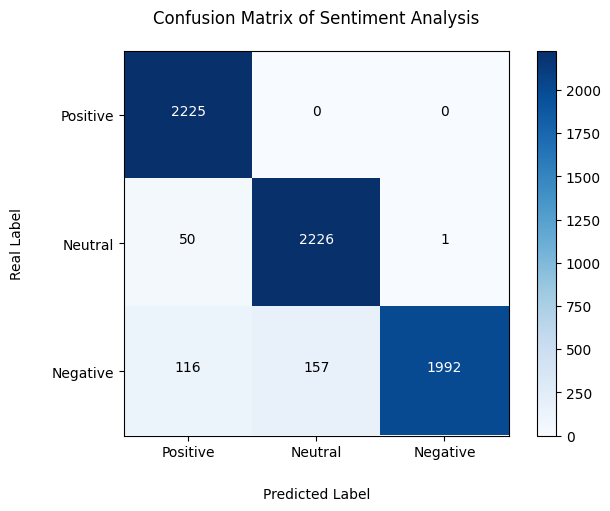

In [ ]:
plot_cm(ConfusionMatrix, classes = ["Positive", "Neutral", "Negative"], title = "Confusion Matrix of Sentiment Analysis")

The insights drawn from the Confusion Matrix are indicative of the model's overall effectiveness. It demonstrates proficiency in accurately classifying both positive and neutral sentiments, although it exhibits some difficulty in distinguishing negative sentiments. This challenge is largely attributed to the imbalanced nature of the initial dataset, but fortunately, the impact has been mitigated through the prior SMOTE resampling

Classification Scores

In [ ]:
print(classification_report(y_test, Prediction))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2225
           1       0.93      0.98      0.96      2277
           2       1.00      0.88      0.94      2265

    accuracy                           0.95      6767
   macro avg       0.95      0.95      0.95      6767
weighted avg       0.95      0.95      0.95      6767



In summary, an impressive F1 Score of 95% has been achieved for each of the sentiment categories, affirming the model's strong performance on the dataset.



---



# Conclusion

**Dataset**


*   The dataset comprises numerous features related to user reviews of musical instruments. However, most of these features are not crucial for sentiment analysis and can be omitted as model variables.

*   Consideration should be given to refraining from removing stopwords during the preprocessing phase, as some of these words could hold significance in determining user sentiments within the model.

*   Text analysis reveals that a significant portion of the transactions is associated with guitars and other string-based instruments. This emphasizes the high level of interest in guitars among customers, suggesting that sellers can prioritize their products in this category.






**Model**

*   A comprehensive assessment of available classification models was conducted, with the 10-Fold Cross Validation revealing that the Logistic Regression Model exhibited the highest accuracy. Consequently, this model was selected for further fine-tuning.

*   During the prediction process on the test set, the achieved accuracy and high F1 Score underscore the model's effectiveness in sentiment analysis.

*   Exploring additional Cross Validation methods, such as Stratified K-Fold, is recommended to potentially obviate the need for dataset resampling. While data scaling is considered optional, it is strongly advised to implement this step.









---

